# 1. Add libraries and define functions

## Load libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, GRU, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

## Normalizing function (based on the train set)

In [ ]:
def normalizing(train_data_input, test_data_input):
    # Create a Min-Max scaler
    scaler = MinMaxScaler()

    # Make copies of input data to avoid modifying the original data
    train_data = train_data_input.copy()
    test_data = test_data_input.copy()

    # Identify columns for normalization
    columns = train_data.columns

    for column in columns:
        
        # Check if the column exists in the test data as well
        if column in train_data.columns and column in test_data.columns:
            
            # Convert the column data to a 2D numpy array for scaling
            train_data[[column]] = scaler.fit_transform(train_data[[column]])
            test_data[[column]] = scaler.transform(test_data[[column]])
            
        else:
            print(f"Warning: Column '{column}' not found in both training and test datasets. Skipping normalization for this column.")

    return train_data, test_data

## Preprocessing

In [ ]:
# Read the dataset, separate the dataset to test and train, normalize the dataset, scale the labels

# Load data from an Excel file
data_file_path = 'Dataset.xlsx'
df = pd.read_excel(data_file_path)

# Extract features (data) and labels
data = df[["Advancing (degree)", "Receding (degree)", "Drop length (cm)", "Drop height (cm)", "Velocity (cm/s)", "Middle line angle (degree)"]]
label = df["Drop width (cm)"]
key = df["Video ID"]
data_status = df["status"]

# Identify test and train sets based on data_status
# The data_status was generated randomly and video-base. We saved it and kept it the same for all models' evaluations.
test_key_set = key[data_status == "test"].unique()
train_key_set = key[data_status == "train"].unique()

test_key = key[data_status == "test"]
train_key = key[data_status == "train"]

test_label = label[data_status == "test"]
train_label = label[data_status == "train"]

test_data = data[data_status == "test"]
train_data = data[data_status == "train"]

# Make a copy of the training data before normalization
train_data_notnormalized = train_data.copy()

# Normalize the training and testing data
train_data, test_data = normalizing(train_data, test_data)

# Scale the label values (convert from cm to µm)
train_label = train_label * 10000
test_label = test_label * 10000


## Slice the data based on the window size

In [ ]:
# Slicing function for the data 

def slicing(data, window_size):
    
    # Convert the input data to a NumPy array
    data = np.array(data)

    # Compute the number of slices based on the specified window_size
    num_slices = data.shape[0] - window_size + 1

    # Create a new array to hold the sliced results
    result = np.zeros((num_slices, window_size, data.shape[1]))

    # Loop through the data and extract adjacent segments of the specified window_size
    for i in range(num_slices):
        result[i, :, :] = data[i : window_size + i, :]

    return result


In [ ]:
# Slicing function for the labels 

def slicing_label(data, window_size):

    # Convert the input data to a NumPy array
    data = np.array(data)

    # Compute the number of slices based on the specified window_size
    num_slices = data.shape[0] - window_size + 1

    # Create a new array to hold the label results
    result = np.zeros((num_slices, 1, data.shape[1]))

    # Loop through the data and extract adjacent segments of the specified window_size
    for i in range(num_slices):
        # Calculate the index for the label in the middle of the segment
        label_index = i + int(window_size / 2)
        result[i, :, :] = data[label_index, :]

    return result


In [ ]:
# Convert the tabular data structure to a sliced dataset suitable for RNNs

# Define the sliding window size
slide_window = 20

# Initialize empty arrays to store sliced data and labels
train_data_sliced = np.empty((0, slide_window, train_data.shape[1]))
train_label_sliced = np.empty((0, 1, 1))

# Loop through unique training keys
for key_set in train_key_set:
    # Filter the training data for the current key
    train_data_temp = train_data[train_key == key_set]
    # Slice the data
    train_data_temp_sliced = slicing(train_data_temp, slide_window)
    # Concatenate the sliced data to the result array
    train_data_sliced = np.concatenate((train_data_sliced, train_data_temp_sliced), axis=0)

    # Filter the training labels for the current key
    train_label_temp = train_label[train_key == key_set]
    # Slice the labels
    train_label_temp_sliced = slicing_label(train_label_temp, slide_window)
    # Concatenate the sliced labels to the result array
    train_label_sliced = np.concatenate((train_label_sliced, train_label_temp_sliced), axis=0)

# 2. Train the LSTM model

In [ ]:
# Determine the number of features from the shape of the sliced training data
num_features = train_data_sliced.shape[-1]

# Split the data into training and validation sets
X_train, X_val, X_label_train, X_label_val = train_test_split(train_data_sliced, train_label_sliced, test_size=0.2, random_state=42)

# Define the input shape based on the sliding window and number of features
input_shape = (slide_window, num_features)

# Define the neural network model
inputs = Input(shape=input_shape)
x = LSTM(units=48, activation='tanh', kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(inputs)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='tanh')(x)

# Determine the maximum and minimum labels in the training label dataset
max_label = np.max(train_label_sliced)
min_label = np.min(train_label_sliced)

# Rescale the model's outputs to match the range of the label time series
outputs = (outputs + 1) / 2 * (max_label - min_label) + min_label

# Create the Keras model by specifying the inputs and outputs
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with the Adam optimizer, mean squared error loss, and mean absolute error metric
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
# Print a summary of the LSTM model structure

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 48)                10560     
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 1)                 49        
                                                                 
 tf.__operators__.add (TFOp  (None, 1)                 0         
 Lambda)                                                         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 1)                 0         
 a)                                                          

In [ ]:
# Train the model

hist = model.fit(X_train, X_label_train, epochs=2500, batch_size=16, validation_data=(X_val, X_label_val), shuffle=True)

Streaming output truncated to the last 5000 lines.
392/392 [==============================] - 9s 17ms/step - loss: 69744.1094 - mae: 196.0375 - val_loss: 39541.7422 - val_mae: 145.5475
Epoch 2/2500
392/392 [==============================] - 6s 15ms/step - loss: 46027.1016 - mae: 162.6957 - val_loss: 41301.9219 - val_mae: 152.6727
Epoch 3/2500
392/392 [==============================] - 4s 11ms/step - loss: 41003.9688 - mae: 155.0291 - val_loss: 29095.9238 - val_mae: 132.1084
Epoch 4/2500
392/392 [==============================] - 6s 16ms/step - loss: 35012.7031 - mae: 144.1019 - val_loss: 25662.8281 - val_mae: 125.3659
Epoch 5/2500
392/392 [==============================] - 5s 13ms/step - loss: 29716.5625 - mae: 132.8284 - val_loss: 22539.4102 - val_mae: 113.7513
Epoch 6/2500
392/392 [==============================] - 5s 14ms/step - loss: 26465.0391 - mae: 124.3410 - val_loss: 18627.8477 - val_mae: 102.4053
Epoch 7/2500
392/392 [==============================] - 6s 14ms/step - loss: 241

## Save and load the model

In [ ]:
# Save the model and its statistics

# Extract training history metrics from the Keras history object
list_loss = hist.history['loss']
list_mae = hist.history['mae']
list_loss_val = hist.history['val_loss']
list_mae_val = hist.history['val_mae']

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'loss': list_loss,
    'mae': list_mae,
    'val_loss': list_loss_val,
    'val_mae': list_mae_val
})

# Specify the Excel file name for saving the metrics
excel_file_name = "LSTM20_metrics.xlsx"

# Save the metrics to an Excel file
metrics_df.to_excel(excel_file_name, index=False)

# Save the model weights to an H5 file
model.save_weights("LSTM20_weights.h5")


In [ ]:
# Load the model (In case of doing experiments)

# Define the path to the model weights file
weights_file_path = "LSTM20_weights.h5"

# Load model weights from the specified file path
model.load_weights(weights_file_path)

# 3. The model validation

## The first video for validation

(3550.0, 4200.0)

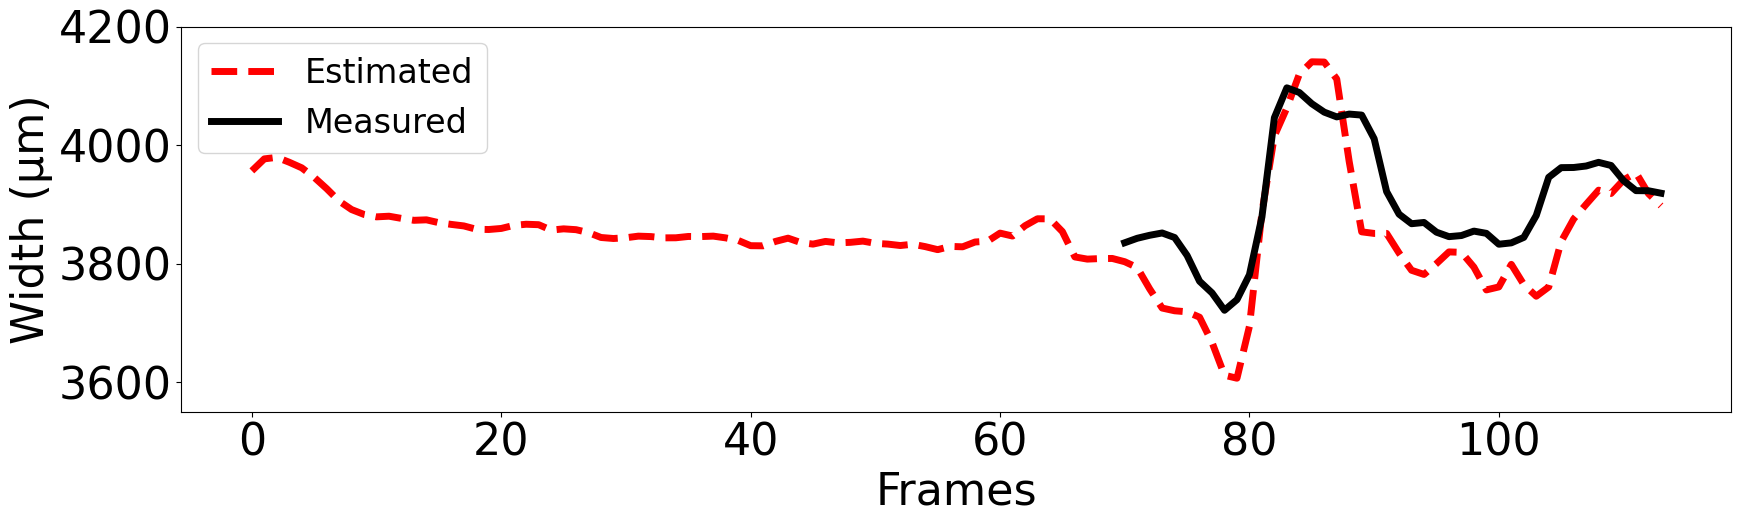

In [ ]:
# Analyze validation video to determine how well the model performs on data that is not part of the dataset

# Load the Excel file into a DataFrame
data_file_path = 'Dataset.xlsx'
df = pd.read_excel(data_file_path)

# Filter the DataFrame for a specific "Video ID" (in this case, Video ID 234 that is related to the final validation measurement on a new sample)
video_id = 234
df_valid = df[df["Video ID"] == video_id]

# Calculate measured width by multiplying "Drop width (cm)" by 10000 (convert cm to µm)
measured_width = df_valid["Drop width (cm)"] * 10000

# Select specific columns in the right order
df_valid = df_valid[["Advancing (degree)", "Receding (degree)", "Drop length (cm)", "Drop height (cm)", "Velocity (cm/s)", "Middle line angle (degree)"]]

# Define the number of empty cells
emptyCellCount = 70

# Normalize the validation data
df_valid = normalizing(train_data_notnormalized, df_valid)[1]

# Perform data slicing using 'slide_window'
df_valid = slicing(df_valid, slide_window)

# Make estimations using the 'model'
y_pred = model.predict(df_valid, verbose=0)
y_pred = y_pred.reshape(1, -1)[0]

# Convert 'measured_width' to a NumPy array and select its required part
measured_width = np.array(measured_width)
measured_width = measured_width[10 + emptyCellCount:-9]

# Plotting configuration
plt.rcParams["figure.figsize"] = (20, 5)
font_size = 32

# Plot the data
plt.xlabel('Frames', fontdict={'size': font_size})
plt.ylabel('Width (μm)', fontdict={'size': font_size})
plt.plot(y_pred, color='red', linestyle='dashed', linewidth=5, label="Estimated")
plt.plot(range(emptyCellCount, emptyCellCount + len(measured_width)), measured_width, "black", linewidth=5, label="Measured")
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)
plt.legend(fontsize=24, loc='upper left')
plt.ylim(3550, 4200)

# NOTE:
'''The estimated diagram's length exceeds that of the measured
diagram because we were able to collect data from side-view sliding
drop videos covering the entire sliding length, which we utilized to
estimate the drop width. However, directly measuring the drop width
using mirrors for the full sliding length, as detailed in the article,
discussed to be unfeasible.'''

RMSE: 86.50748901154577


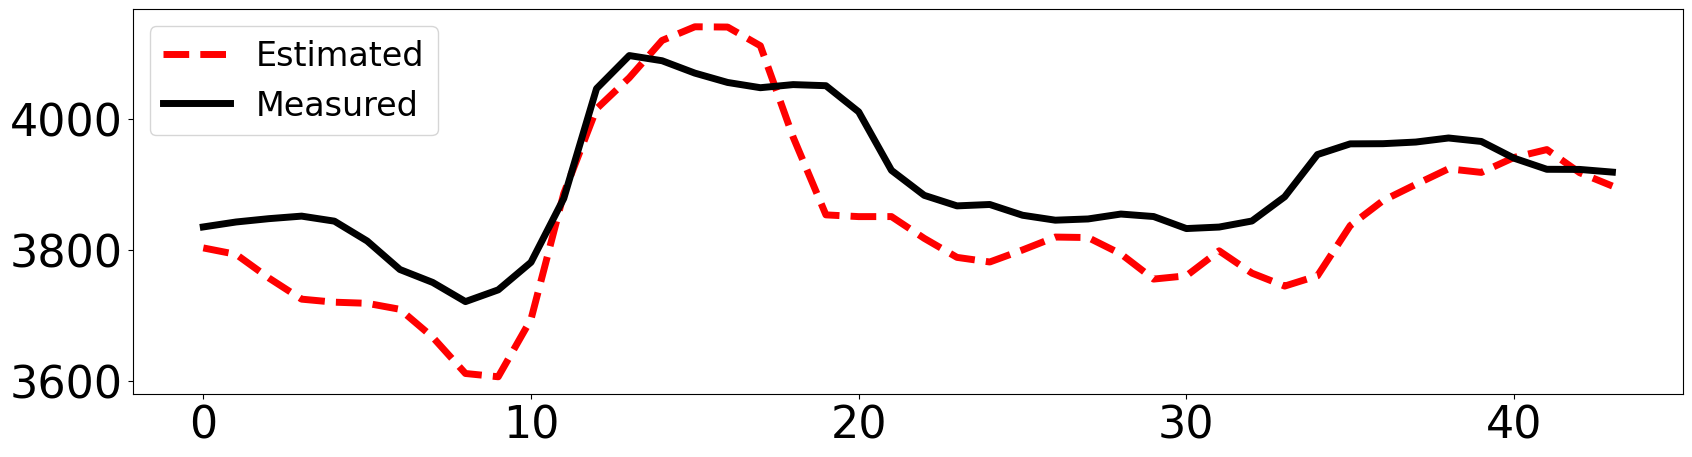

In [ ]:
# Calculate RMSE based on the overlap between measured and estimated diagrams

# Extract estimated values starting from 'emptyCellCount'
y_pred_error_measurement = y_pred[emptyCellCount:]

# Plot the estimated and measured values
plt.plot(y_pred_error_measurement, color='red', linestyle='dashed', linewidth=5, label="Estimated")
plt.plot(measured_width, "black", linewidth=5, label="Measured")
plt.legend(fontsize=24, loc='upper left')

# Calculate the Root Mean Squared Error (RMSE) between measured and estimated values
rmse = np.sqrt(np.square(measured_width - y_pred_error_measurement).mean())
print("RMSE:", rmse)


## The second video for validation

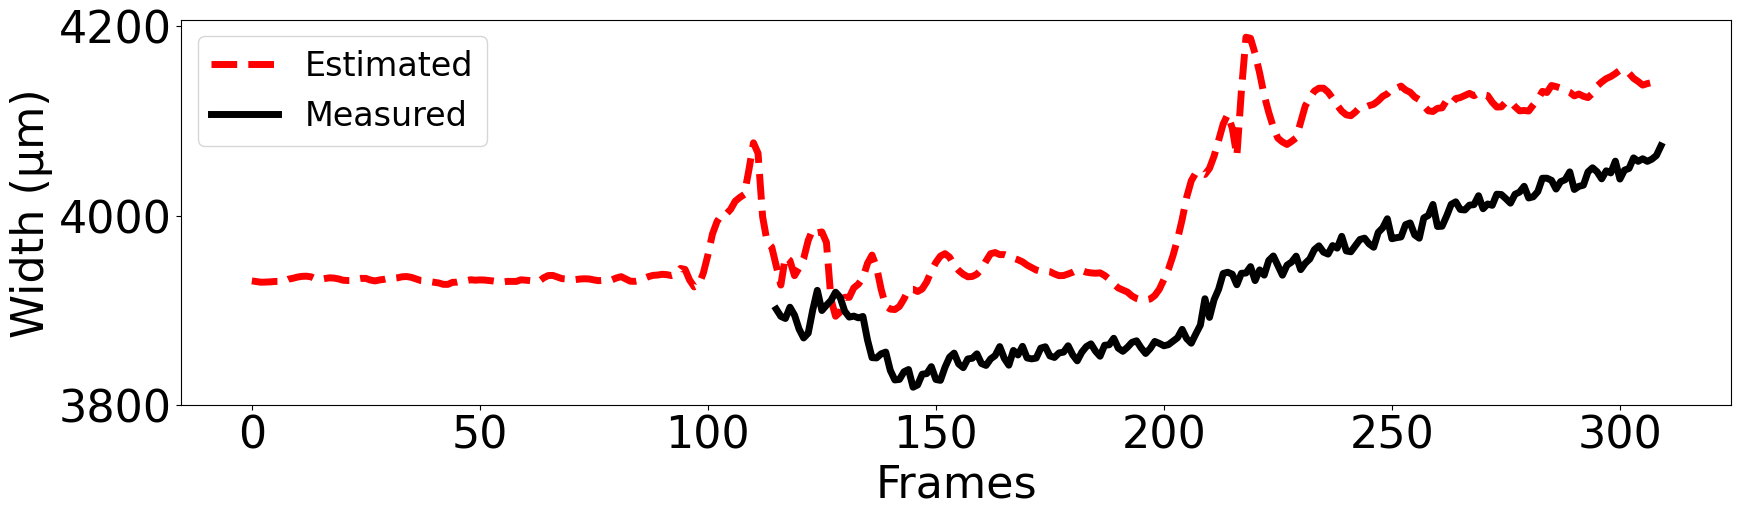

In [ ]:
# Analyze validation video to determine how well the model performs on data that is not part of the dataset

# Load the Excel file into a DataFrame
data_file_path = 'Dataset.xlsx'
df = pd.read_excel(data_file_path)

# Filter the DataFrame for a specific "Video ID" (in this case, Video ID 14 that is related to the final validation measurement on a new sample)
video_id = 14
df_valid = df[df["Video ID"] == video_id]

# Calculate measured width by multiplying "Drop width (cm)" by 10000 (convert cm to µm)
measured_width = df_valid["Drop width (cm)"] * 10000

# Select specific columns in the right order
df_valid = df_valid[["Advancing (degree)", "Receding (degree)", "Drop length (cm)", "Drop height (cm)", "Velocity (cm/s)", "Middle line angle (degree)"]]

# Define the number of empty cells
emptyCellCount = 115

# Normalize the validation data
df_valid = normalizing(train_data_notnormalized, df_valid)[1]

# Perform data slicing using 'slide_window'
df_valid = slicing(df_valid, slide_window)

# Make estimations using the 'model'
y_pred = model.predict(df_valid, verbose=0)
y_pred = y_pred.reshape(1, -1)[0]

# Convert 'measured_width' to a NumPy array and apply slicing
measured_width = np.array(measured_width)
measured_width = measured_width[10 + emptyCellCount:-9]

# Plotting configuration
plt.rcParams["figure.figsize"] = (20, 5)
font_size = 32

# Plot the data
plt.xlabel('Frames', fontdict={'size': font_size})
plt.ylabel('Width (μm)', fontdict={'size': font_size})
plt.plot(y_pred, color='red', linestyle='dashed', linewidth=5, label="Estimated")
plt.plot(range(emptyCellCount, emptyCellCount + len(measured_width)), measured_width, "black", linewidth=5, label="Measured")
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)
plt.legend(fontsize=24, loc='upper left')



RMSE: 112.56827652755662


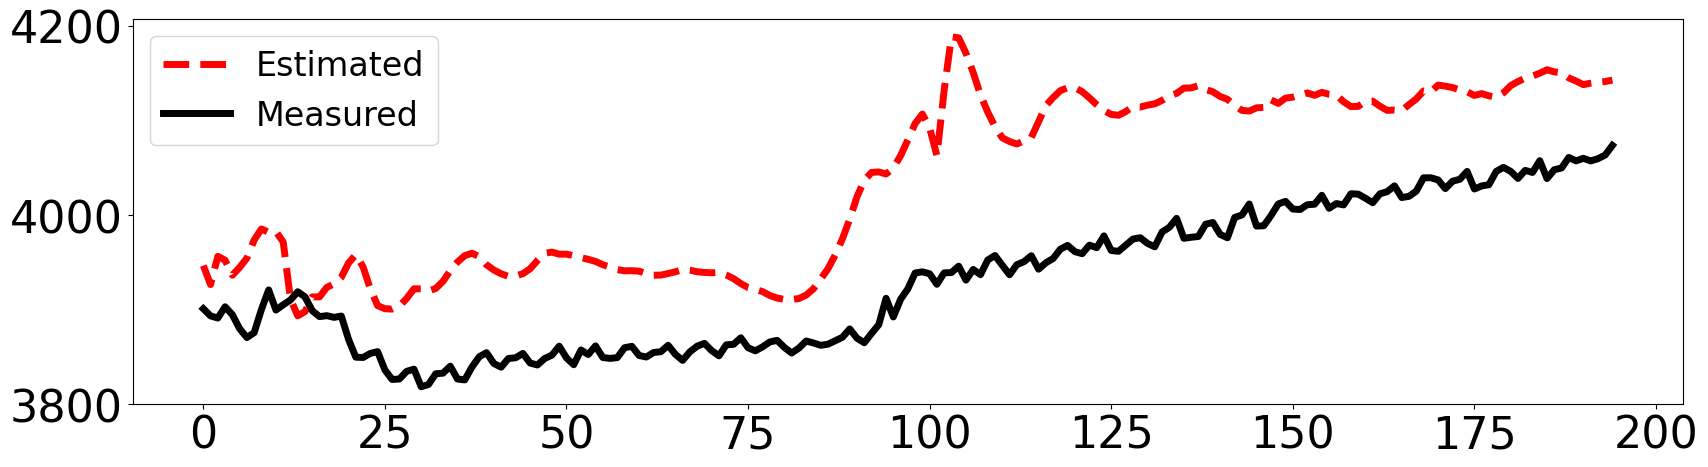

In [ ]:
# Calculate RMSE based on the overlap between measured and estimated diagrams

# Extract estimated values starting from 'emptyCellCount'
y_pred_error_measurement = y_pred[emptyCellCount:]

# Plot the estimated and measured values
plt.plot(y_pred_error_measurement, color='red', linestyle='dashed', linewidth=5, label="Estimated")
plt.plot(measured_width, "black", linewidth=5, label="Measured")
plt.legend(fontsize=24, loc='upper left')

# Calculate the Root Mean Squared Error (RMSE) between measured and estimated values
rmse = np.sqrt(np.square(measured_width - y_pred_error_measurement).mean())
print("RMSE:", rmse)